# Train SRResNet x4

In [1]:
import os
import csv
import random
import torch
from pathlib import Path
from torch import optim
from torch.optim import lr_scheduler
from tqdm.auto import tqdm
from IPython.display import clear_output

from data import build_loader
from original_model import SRResNet
from losses import PixelLoss
from engine import train_srresnet_epoch, val_srresnet_epoch
from vis import show_lr_sr_hr, plot_curves


e:\(venv) Python 3.13.0\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_dataset, train_loader = build_loader(
    cfg['paths']['train_lr'], cfg['paths']['train_hr'],
    scale=cfg['scale'], hr_crop=cfg['hr_crop'],
    batch_size=cfg['train']['batch_size'],
    num_workers=cfg['train']['num_workers'],
    train=True
)
val_dataset, val_loader = build_loader(
    cfg['paths']['val_lr'], cfg['paths']['val_hr'],
    scale=cfg['scale'], hr_crop=cfg['hr_crop'],
    batch_size=32,
    num_workers=cfg['train']['num_workers'],
    train=False
)


In [ ]:
# Config override here
from pathlib import Path

data_root = Path('..') / 'input'

cfg['paths']['train_lr'] = str(data_root / 'train' / 'train_lr')
cfg['paths']['train_hr'] = str(data_root / 'train' / 'train_hr')
cfg['paths']['val_lr'] = str(data_root / 'val' / 'val_lr')
cfg['paths']['val_hr'] = str(data_root / 'val' / 'val_hr')
cfg['paths']['test_lr'] = str(data_root / 'test' / 'test_lr')
cfg['paths']['test_hr'] = str(data_root / 'test' / 'test_hr')


In [ ]:
from original_model import SRResNet as SRResNetOrig

generator = SRResNetOrig(upscale=cfg['scale']).to(device)
ckpt = torch.load('weights/SRGAN_x4-ImageNet.pth.tar', map_location=device)

if isinstance(ckpt, dict):
    if 'generator' in ckpt:
        state = ckpt['generator']
    elif 'model' in ckpt:
        state = ckpt['model']
    elif 'state_dict' in ckpt:
        state = ckpt['state_dict']
    else:
        state = ckpt
else:
    state = ckpt

if isinstance(state, dict) and any(k.startswith('_orig_mod.') for k in state):
    state = {k.replace('_orig_mod.', ''): v for k, v in state.items()}

generator.load_state_dict(sr_state)
optimizer = optim.Adam(generator.parameters(), lr=cfg['train']['lr'])
scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
pixel_criterion = PixelLoss().to(device)


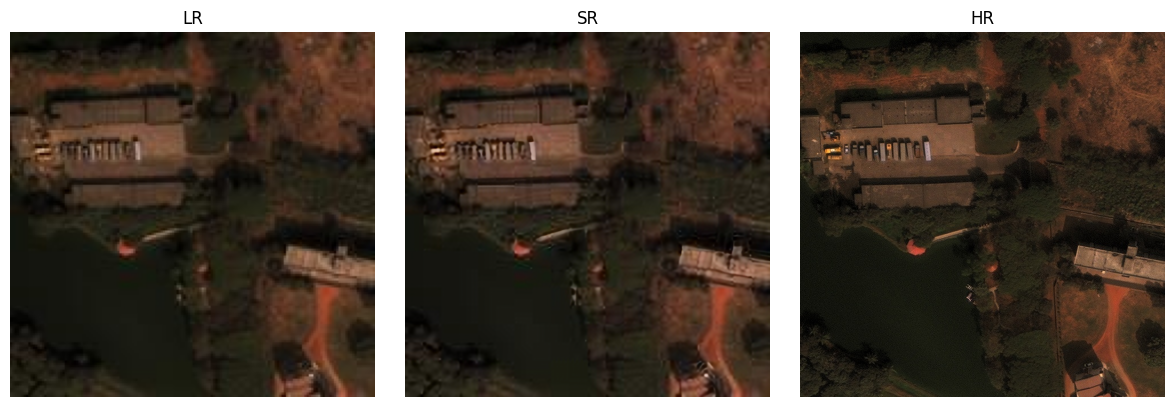

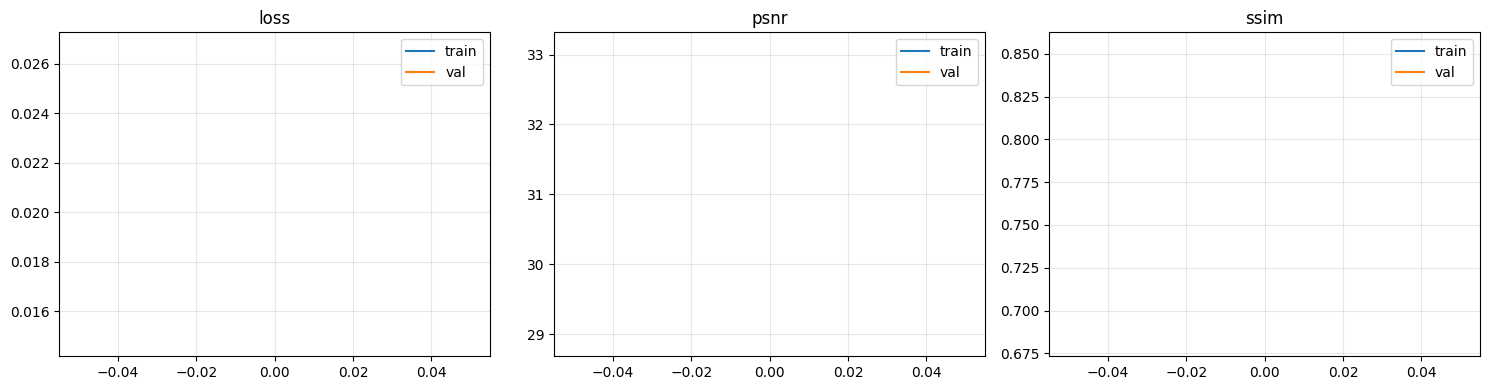

Epoch 2/150 [Val]:   0%|          | 0/1 [00:13<?, ?it/s]


KeyboardInterrupt: 

In [5]:
history = {
    'loss': {'train': [], 'val': []},
    'psnr': {'train': [], 'val': []},
    'ssim': {'train': [], 'val': []},
}
log_dir = 'logs'
os.makedirs(log_dir, exist_ok=True)
log_path = os.path.join(log_dir, 'srresnet_log.csv')
if not os.path.exists(log_path):
    with open(log_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['epoch', 'train_loss', 'val_loss', 'train_psnr', 'val_psnr', 'train_ssim', 'val_ssim'])
best_psnr = -1.0
epochs = cfg['train']['epochs']

for epoch in range(1, epochs + 1):
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{epochs} [Train]')
    train_stats = train_srresnet_epoch(generator, train_pbar, optimizer, device, pixel_criterion)

    val_pbar = tqdm(val_loader, desc=f'Epoch {epoch}/{epochs} [Val]')
    val_stats = val_srresnet_epoch(generator, val_pbar, device, pixel_criterion)

    scheduler.step()

    history['loss']['train'].append(train_stats['loss'])
    history['loss']['val'].append(val_stats['loss'])
    history['psnr']['train'].append(train_stats['psnr'])
    history['psnr']['val'].append(val_stats['psnr'])
    history['ssim']['train'].append(train_stats['ssim'])
    history['ssim']['val'].append(val_stats['ssim'])

    with open(log_path, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            epoch,
            train_stats['loss'],
            val_stats['loss'],
            train_stats['psnr'],
            val_stats['psnr'],
            train_stats['ssim'],
            val_stats['ssim'],
        ])

    torch.save(generator.state_dict(), 'weights/last_srresnet.pth')
    if val_stats['psnr'] > best_psnr:
        best_psnr = val_stats['psnr']
        torch.save(generator.state_dict(), 'weights/best_srresnet.pth')

    clear_output(wait=True)

    # Random sample visualization
    rand_idx = random.randint(0, len(val_dataset) - 1)
    lr_sample, hr_sample = val_dataset[rand_idx]
    lr_in = lr_sample.unsqueeze(0).to(device)
    with torch.no_grad():
        sr_sample = generator(lr_in).cpu()
    show_lr_sr_hr(lr_sample, sr_sample, hr_sample)

    # Curves
    plot_curves(history)
